In [35]:
!pip install lightgbm 
!pip install catboost 
!pip install sklearn  
!pip install xgboost 

     |████████████████████████████████| 67.4 MB 27 kB/s 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
##from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

In [24]:
c = pd.read_csv("/content/creditcard.csv")

In [3]:
c.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
c.isnull()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
284803,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
284804,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
284805,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [6]:
c['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [7]:
NF = len(c[c.Class == 0])
F = len(c[c.Class == 1])
total = F + NF
Fraud_P  =  F / (F + NF) * 100



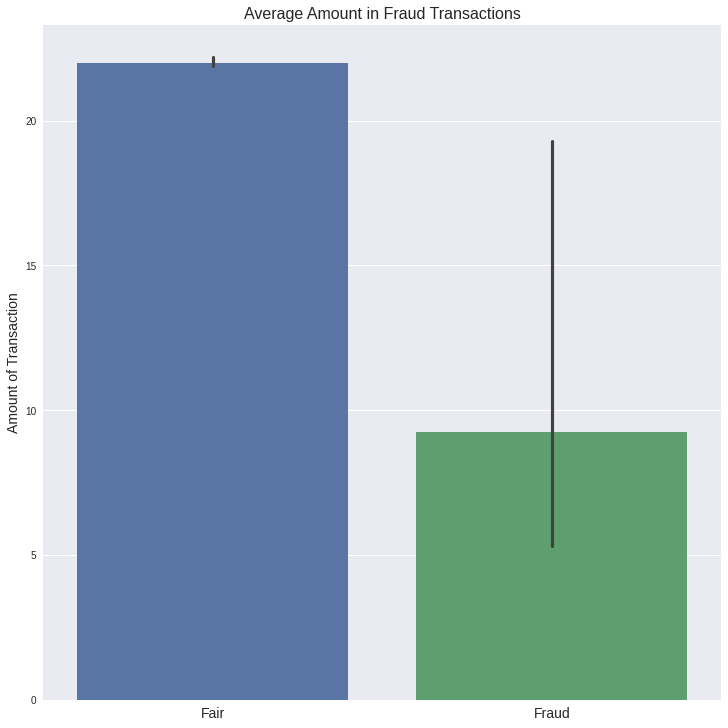

In [8]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1 ,1, figsize = (10, 10), constrained_layout = True)

# I used median instead of mean to avoid outliers
ax = sns.barplot(x = 'Class', y = 'Amount', data = c, estimator = np.median, ax = ax)

plt.title("Average Amount in Fraud Transactions", size = 16)

ax.set_xticklabels(['Fair', 'Fraud'], fontsize = 14)

plt.xlabel(None)
plt.ylabel('Amount of Transaction', fontsize = 14);

In [9]:
class_0 = c.loc[c['Class'] == 0]["Time"]
class_1 = c.loc[c['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

In [10]:
c['Hour'] = c['Time'].apply(lambda x: np.floor(x / 3600))

tmp = c.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


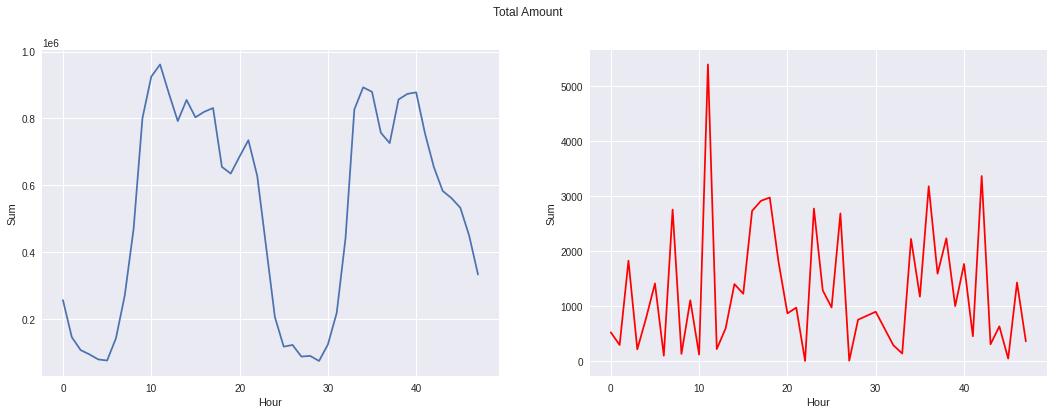

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

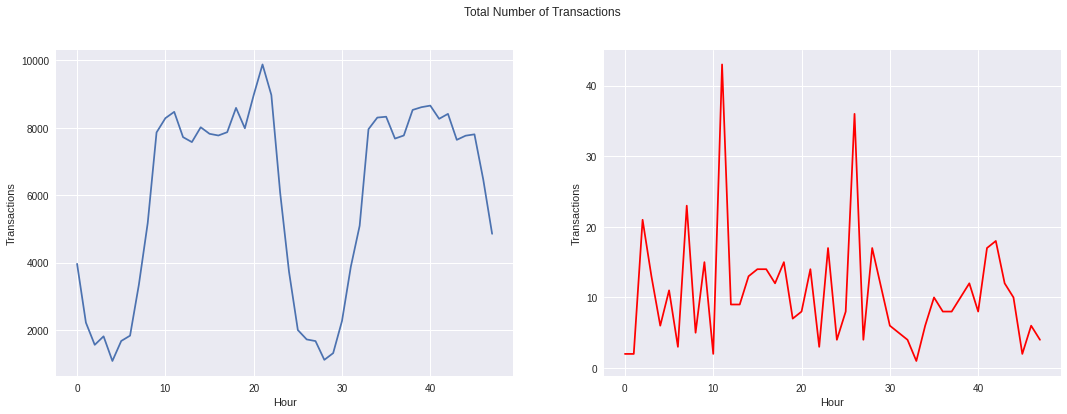

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

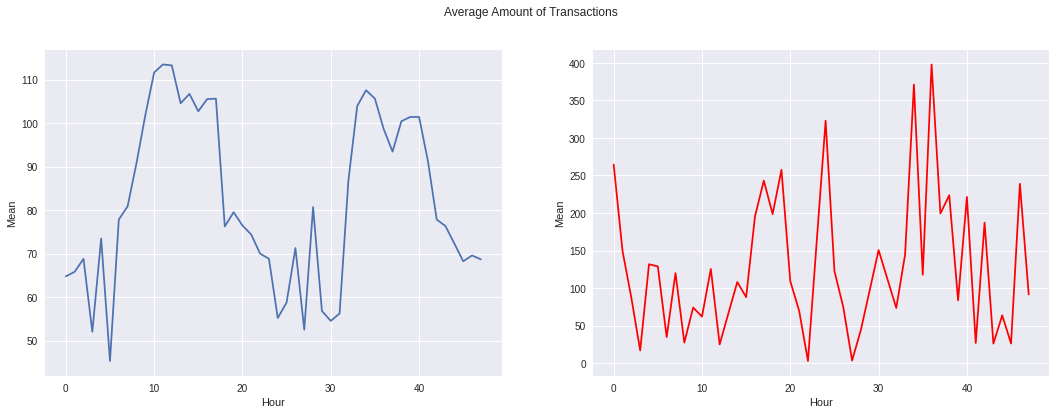

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

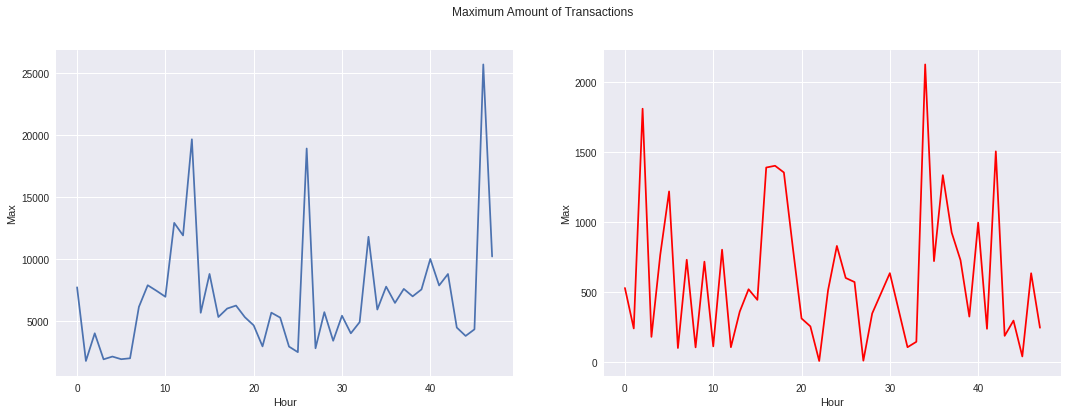

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

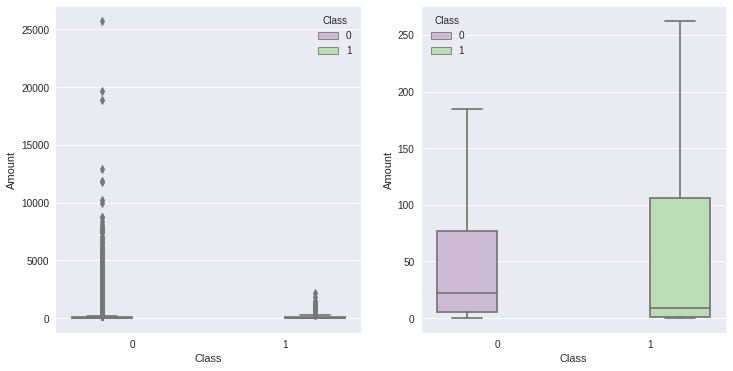

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=c, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=c, palette="PRGn",showfliers=False)
plt.show();

In [16]:
tmp = c[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [18]:
fraud = c.loc[c['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

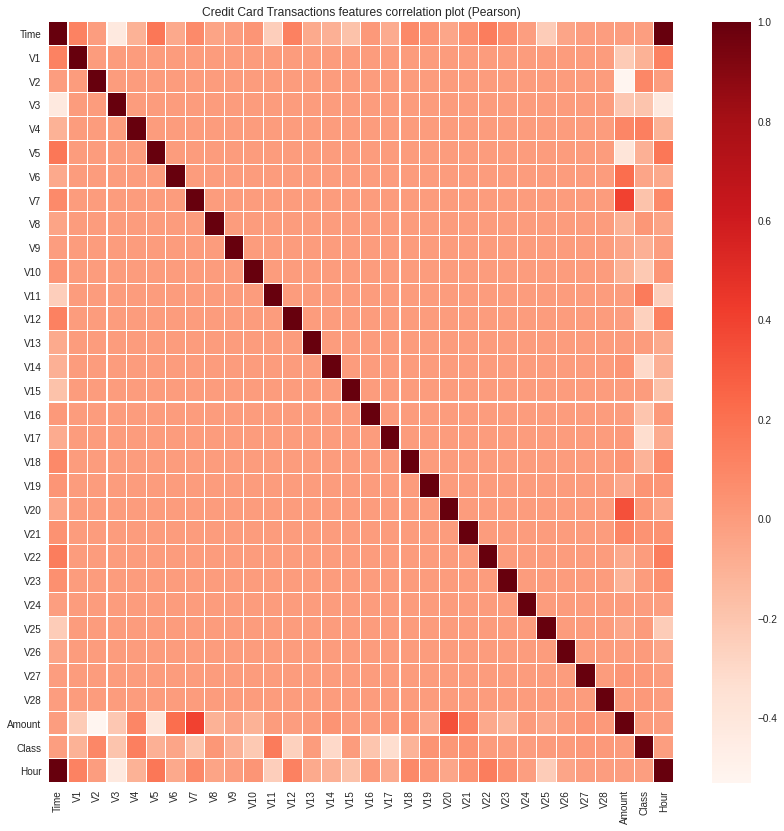

In [19]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = c.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

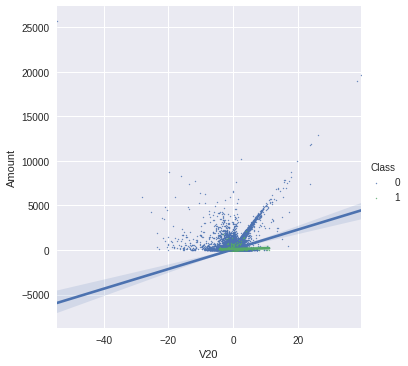

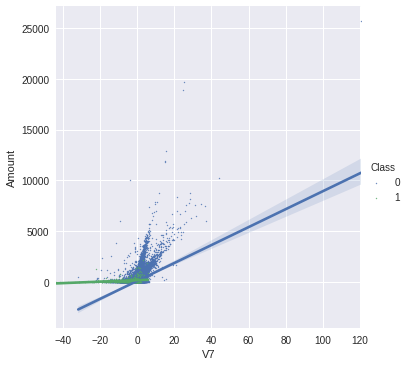

In [20]:
s = sns.lmplot(x='V20', y='Amount',data=c, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=c, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

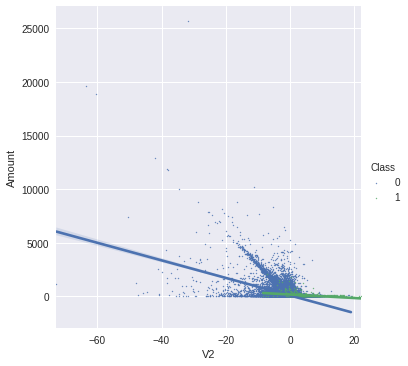

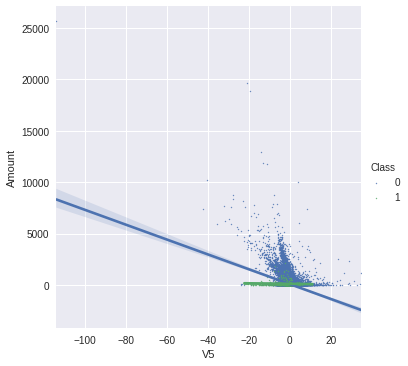

In [21]:
s = sns.lmplot(x='V2', y='Amount',data=c, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=c, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parame

<Figure size 576x396 with 0 Axes>

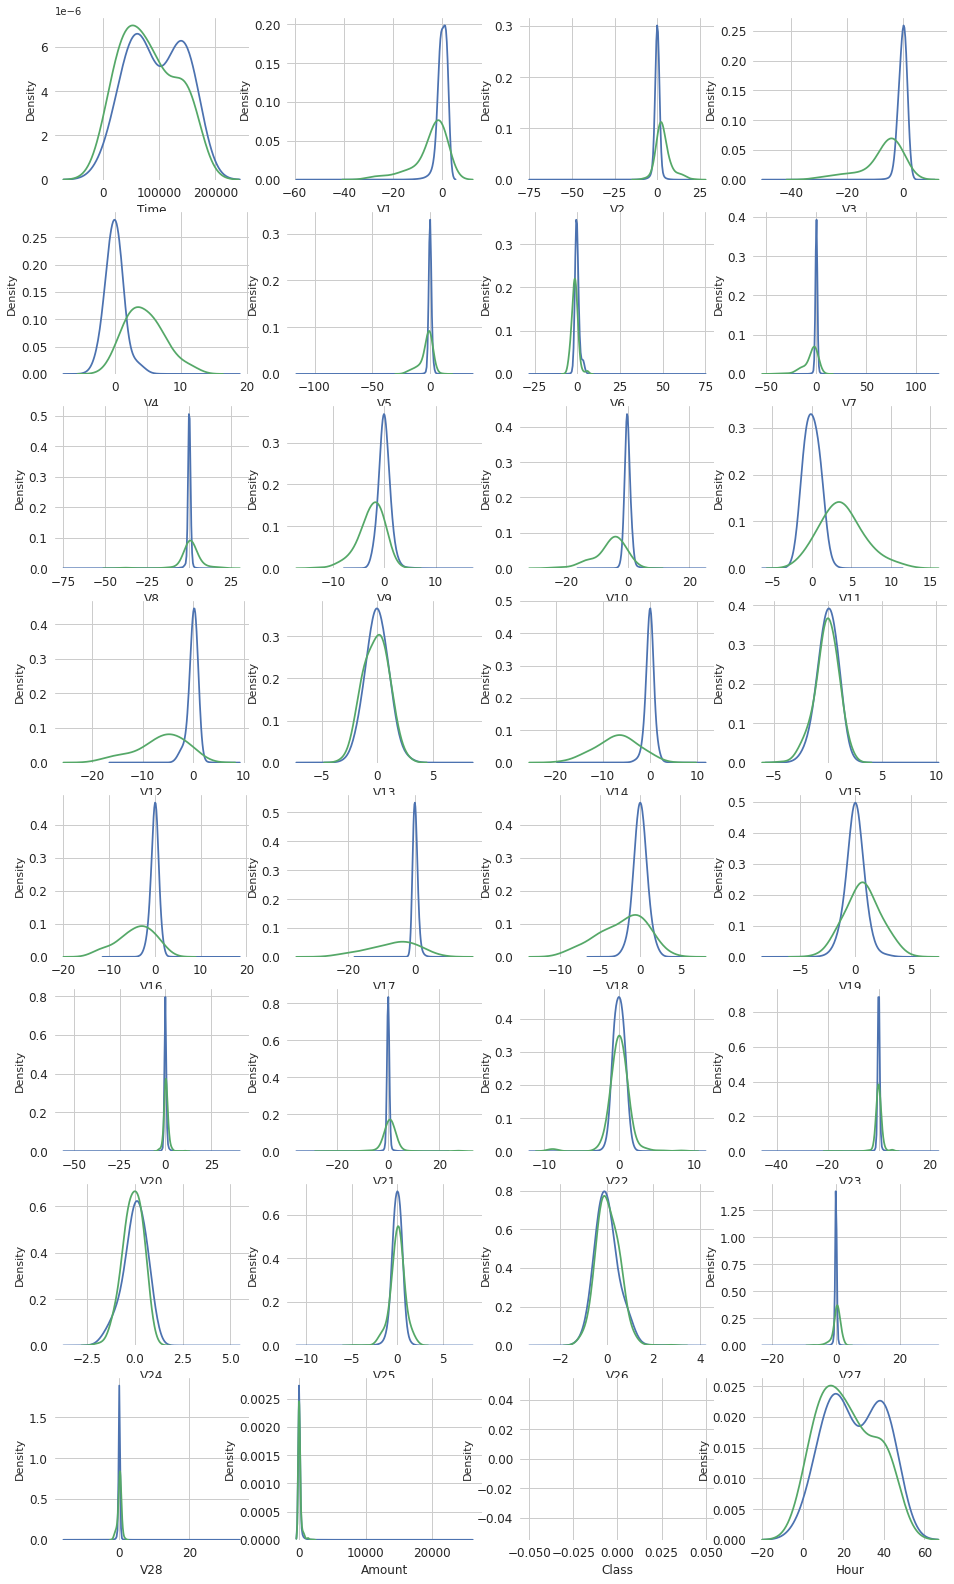

In [22]:
var = c.columns.values

i = 0
t0 = c.loc[c['Class'] == 0]
t1 = c.loc[c['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [23]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [27]:
train_c, test_c = train_test_split(c, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_c, valid_c = train_test_split(c, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [29]:
ranfor = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [30]:
ranfor.fit(train_c[predictors], train_c[target].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=2018, verbose=False,
                       warm_start=False)

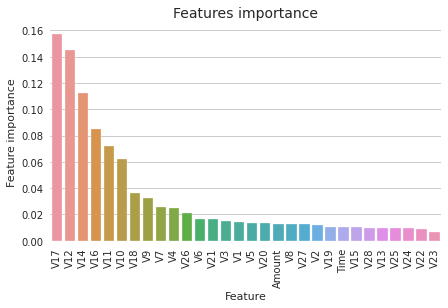

In [31]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': ranfor.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

In [37]:
preds = ranfor.predict(valid_c[predictors])

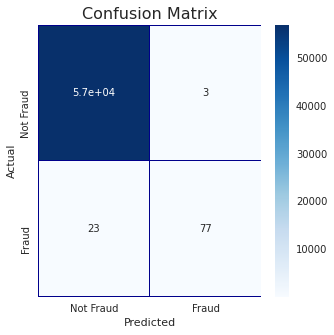

In [39]:
bhu = pd.crosstab(valid_c[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(bhu, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [40]:
clfs = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [42]:
clfs.fit(train_c[predictors], train_c[target].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=2018)

In [44]:
preds = clfs.predict(valid_c[predictors])

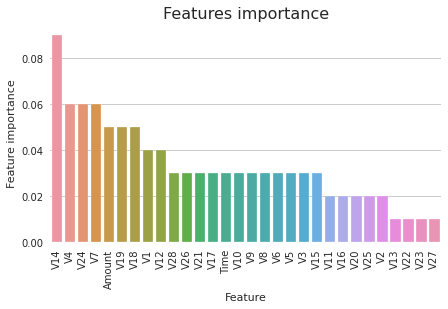

In [45]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clfs.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=16)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

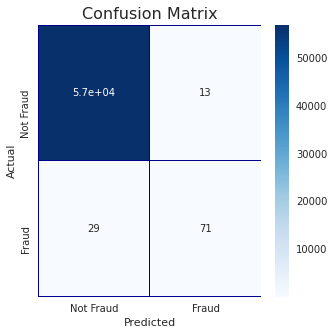

In [49]:
bhu = pd.crosstab(valid_c[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(bhu, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [51]:
roc_auc_score(valid_c[target].values, preds)

0.8548856881572932

In [52]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [56]:
dtrain = lgb.Dataset(train_c[predictors].values, 
                     label=train_c[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_c[predictors].values,
                     label=valid_c[target].values,
                     feature_name=predictors)

In [57]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.870175	valid's auc: 0.862687
[100]	train's auc: 0.961406	valid's auc: 0.915406
[150]	train's auc: 0.97505	valid's auc: 0.917517
[200]	train's auc: 0.980613	valid's auc: 0.917409
[250]	train's auc: 0.977099	valid's auc: 0.914674
[300]	train's auc: 0.980159	valid's auc: 0.927868
Early stopping, best iteration is:
[219]	train's auc: 0.98134	valid's auc: 0.917042


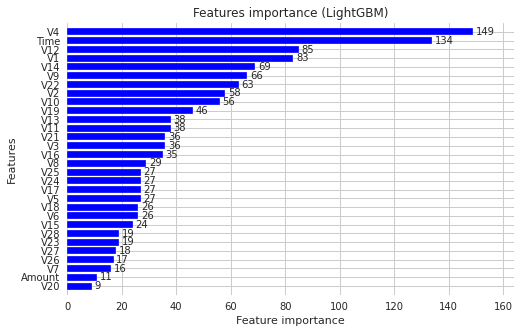

In [58]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="blue") 
plt.show()

In [60]:
preds = model.predict(test_c[predictors])

In [62]:
roc_auc_score(test_c[target].values, preds)

0.9142672610882487

In [67]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_c.shape[0])
test_preds = np.zeros(test_c.shape[0])
feature_importance_c = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_c):
    train_x, train_y = train_c[predictors].iloc[train_idx],train_c[target].iloc[train_idx]
    valid_x, valid_y = train_c[predictors].iloc[valid_idx],train_c[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_c[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_c = pd.DataFrame()
    fold_importance_c["feature"] = predictors
    fold_importance_c["importance"] = clfs.feature_importances_
    fold_importance_c["fold"] = n_fold + 1
    
    feature_importance_c = pd.concat([feature_importance_c, fold_importance_c], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_c[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.969982	valid_1's auc: 0.956724
Early stopping, best iteration is:
[8]	training's auc: 0.971798	valid_1's auc: 0.964439
Fold  1 AUC : 0.964439
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.974302	valid_1's auc: 0.978253
[100]	training's auc: 0.975336	valid_1's auc: 0.981454
Early stopping, best iteration is:
[88]	training's auc: 0.974214	valid_1's auc: 0.981896
Fold  2 AUC : 0.981896
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.974499	valid_1's auc: 0.989491
Early stopping, best iteration is:
[14]	training's auc: 0.976349	valid_1's auc: 0.988911
Fold  3 AUC : 0.988911
Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.978521	valid_1's auc: 0.950608
[100]	training's auc: 0.979912	valid_1's auc: 0.952193
[150]	training's auc: 0.980729	valid_1's auc: 0.954916
[200]	training's auc: 0.981625	valid

In [68]:
pred = test_preds